In [1]:
import pandas as pd
import gzip
import itertools
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


###### convert json data to pandas data frame

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Digital_Music_5.json.gz')
df.head(2)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5.0,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5.0,Enya at her most elegant,991526400,"06 3, 2001"


##### 1. Start by inspecting the dataset. You will notice that the dataset is not balanced. Display the count of reviews with overall rating =1, 2...5.

###### Display the count of reviews with overall rating =1,2...5.

In [3]:
print(df.groupby('overall').count()['reviewText'])

overall
1.0     2791
2.0     3010
3.0     6789
4.0    16536
5.0    35580
Name: reviewText, dtype: int64


##### 2. To train on a balanced dataset, select 2500 reviews for each of the overall ratings

###### select 2500 reviews for each of the overall ratings

In [4]:
df = df.groupby("overall").head(2500)

print("Number of overall rating of 5.0:" , df[df['overall'] == 5.0]['reviewText'].count())
print("Number of overall rating of 4.0:" , df[df['overall'] == 4.0]['reviewText'].count())
print("Number of overall rating of 3.0:" , df[df['overall'] == 3.0]['reviewText'].count())
print("Number of overall rating of 2.0:" , df[df['overall'] == 2.0]['reviewText'].count())
print("Number of overall rating of 1.0:" , df[df['overall'] == 1.0]['reviewText'].count())



Number of overall rating of 5.0: 2500
Number of overall rating of 4.0: 2500
Number of overall rating of 3.0: 2500
Number of overall rating of 2.0: 2500
Number of overall rating of 1.0: 2500


###### choose the most relevant column from the df which is 'reviewText'

In [5]:
x = np.array(df["reviewText"])
y = np.array(df['overall'])

###### 4. divide the dataset into training, testing and validation sets

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

###### 3. transform review words to numeric features

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=40000)
X_train_transformed = tfidf_vectorizer.fit_transform(X_train)
X_test_transformed = tfidf_vectorizer.transform(X_test)

###### create the MLP classifier

In [8]:
clf = MLPClassifier(early_stopping=True)
clf.fit(X_train_transformed, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

##### 5. Use the appropriate scoring metric for evaluating your neural networks.

In [9]:
# using accuracy scoring metrix for evaluating the nueral network
# because it's the most suitable when dealing with a balanced dataset
metrics.accuracy_score(clf.predict(X_test_transformed), Y_test)

0.612

##### 6. Attempt to train a neural network with 1, 2 or 3 layers and different number of nodes [128, 512, 1024].

###### trying 1 hidden layer with 128 nodes

In [10]:
clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(128,))
clf.fit(X_train_transformed, Y_train)

metrics.accuracy_score(clf.predict(X_test_transformed), Y_test)
#increasing the number of nodes in the hidden layer did not contribute in enhancing the performance.

0.6148

###### trying 2 hidden layers with different number of nodes

In [9]:
clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 512))
clf.fit(X_train_transformed, Y_train)

metrics.accuracy_score(clf.predict(X_test_transformed), Y_test)
# performance did not get better

0.6084

###### trying 3 hidden layers with different number of nodes

In [11]:
clf = MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 512, 1024,))
clf.fit(X_train_transformed, Y_train)

metrics.accuracy_score(clf.predict(X_test_transformed), Y_test)
# worst architecture because the validation score is the lowest here

0.5896

 1 hidden layer with number of nodes = 128 has the best performance sofar.

##### 7.plot the normalized confusion matrix for the best performing architecture

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

###### Compute the confusion matrix

In [13]:
y_pred = clf.predict(X_test_transformed)
cnf_matrix = confusion_matrix(Y_test, y_pred)
np.set_printoptions(precision=2)


###### Plot normalized confusion matrix

Normalized confusion matrix
[[0.71 0.18 0.07 0.02 0.01]
 [0.26 0.44 0.25 0.03 0.02]
 [0.04 0.12 0.56 0.23 0.06]
 [0.03 0.03 0.18 0.61 0.15]
 [0.02 0.02 0.03 0.16 0.77]]


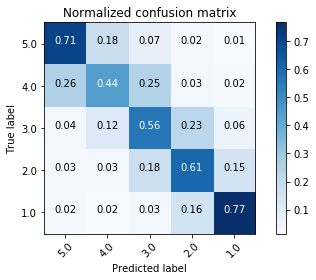

In [14]:
plt.figure()
class_names = ['5.0', '4.0', '3.0', '2.0','1.0']
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# Accroding to the confusion matrix plot results:
# class 1.0: about 24% only of class 1.0 reviews were misclassified which is not bad.

# class 2.0: about 40% of class 2 reviews were misclassified and
# the reason why this class has more missclassifications that class 1.0
# might be that reviews that indicates unsatisfiction are more likely to have rating of 1 rather than 2 .

# class 3.0: about 50% of data points belonging to this class were misclassified 
# and it might be that nuetral reviews can not be easily detected so they were classfied either as class 2.0 or 4.0

# class 4.0: about 47% of data points belonging to this class were misclassified 
# and it might be that because some poeple are showing high levels of satisfiction but still giving rating of 4.0.

# class 5.0: about 30% only of this class reviews were misclassified which is good enough.

# classes 5.0 and 1.0 are the easiest to classify because they might contain strong expressions that made it easier 
# for the nueral network to make correct classifications. 
# unlike classses 2.0 , 3.0 and 4.0 that might contain nuetral expressions
# which makes it harder  for the network to classify them.


###### 8. What is the activation function used at the output layer? Did you have to select this function yourself? How does SKLearn determines it?

In [16]:
clf.out_activation_

'softmax'

the activation function used at the output layer is 'softmax'.
No, i did not have to specify it.
SKLearn uses softmax by default for multiclass models

the reason for using the softmax is to ensure logits all sum up to 1, thereby fulfilling the constraints of a probability density. If we are try to predict whether a medical image contain cancer or not (simply yes or no), then the probability of a positive result (yes) and a negative result (no) must sum up to one. o the model produces a probability vector for each outcome.

# Bonus

##### 1. Print out the actual rating and predicted values for part of the test set.

In [45]:
print("Actual ratings for the first 3 reviews\n" , Y_test[:3].reshape(3,1))
print("Predicted ratings for the first 3 reviews\n" , y_pred[:3].reshape(3,1))

Actual ratings for the first 3 reviews
 [[3.]
 [1.]
 [5.]]
Predicted ratings for the first 3 reviews
 [[4.]
 [2.]
 [5.]]


###### 2. Describe how the network fails, causing the low test and validation scores.

the network fails because text data are ambigious and the data set was not preproccessed appropriatly to make sure that no redundant data points exist, such as stops words and punctuations.

#### 3. Suggest a modification in the network (type, dataset, output format, scoring metric) that best fits the network behavior you observed in the previous step.

a) Change output format to int and use average_precision scoring matrix.
b) Preprocess data using the following steps: 
1- tokenize 
2- modify tokens by removing stop words,
3- normalize
4- stemm 
5- case folding.

c) Increase the number of feature_count to 80000 instead of 4000
d) Replace the binary numbers in the word vector with ratios that emphaise how rare (and hence meanigful and representative) the word is across all reviews.